# Talking Data

The purpose of this project is to use mobile user data to predict the age group of the user.  The age groups are split betweeen either female or male, then from below 23,to above 43.  Here is what it looks for females: F23-, F24-26, F27-28, F29-32, F33-42, F43+. 

The data is from the Chinese company TalkingData. There are several data sets, each a unique csv: gender_age_train, gender_age_test, events, app_events, app_labels, label_categories and phone_brand_device_model.  

In [92]:
#Importing the packages needed for this analysis
from pygeocoder import Geocoder
import pandas as pd
import io
import numpy as np
import seaborn as sns
from sklearn.metrics import log_loss
import pickle
import math
import re
import reverse_geocoder as rg
from datetime import *
from scipy import stats
import dateutil.parser
from IPython.display import display
from sklearn import preprocessing
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from IPython.core.interactiveshell import InteractiveShell
import goslate
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%config InlineBackend.figure_format = 'png'

plt.rcParams['figure.dpi']= 450

In [93]:
#Connecting to SQL database on an AWS EC2 instance
from sqlalchemy import create_engine
import pandas as pdb
cnx = create_engine('postgresql://djmor@34.234.69.231/djmor')

In [94]:
#Loading in coordinates to fast track reverse geocoding
geo = rg.RGeocoder(mode=2, verbose=True, stream=io.StringIO(open('rg_cities1000.csv', encoding='utf-8').read()))

In [95]:
#List of classification types 
classes = {'F23-':0, 'F24-26':1,'F27-28':2,'F29-32':3, 'F33-42':4, 'F43+':5, 'M22-':6, 'M23-26':7, 'M27-28':8, 'M29-31':9, 'M32-38':10, 'M39+':11}
clas = ['F23-', 'F24-26','F27-28','F29-32', 'F33-42', 'F43+', 'M22-', 'M23-26', 'M27-28', 'M29-31', 'M32-38', 'M39+']
           

In [96]:
#Creating all the data frames
device_brand = pd.read_csv('phone_brand_device_model.csv')
applabeldf = pd.read_csv('app_labels.csv')
labelcat = pd.read_csv('label_categories.csv')
genderdf = pd.read_csv('gender_age_train.csv')
eventsdf = pd.read_csv('~/Documents/events.csv')
appevents = pd.read_csv('~/Documents/app_events.csv')
testdf = pd.read_csv('gender_age_test.csv')

In [97]:
testdf.head()
genderdf.head()
genderdf.shape

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


(74645, 4)

In [98]:
device_brand = device_brand.drop_duplicates('device_id',keep='first')
testdf = testdf.drop_duplicates('device_id',keep='first')
genderdf.group = genderdf.group.map(classes)

In [99]:
genderdf

,device_id,gender,age,group
0,-8076087639492063270,M,35,10
1,-2897161552818060146,M,35,10
2,-8260683887967679142,M,35,10
3,-4938849341048082022,M,30,9
4,245133531816851882,M,30,9
5,-1297074871525174196,F,24,1
6,236877999787307864,M,36,10
7,-8098239495777311881,M,38,10
8,176515041953473526,M,33,10
9,1596610250680140042,F,36,4


In [100]:
#Getting an idea on how each df connects with each other
device_brand.head()
appevents.head()
labelcat.head()
eventsdf.head()
applabeldf.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [101]:
#Translating Phone brand to English for easier comprehension
translate = {'三星':'samsung','天语':'Ktouch','海信':'hisense','联想':'lenovo','欧比':'obi','爱派尔':'ipair','努比亚':'nubia',\
             '优米':'youmi','朵唯':'dowe','黑米':'heymi','锤子':'hammer','酷比魔方':'koobee','美图':'meitu','尼比鲁':'nibilu','一加':'oneplus','优购':'yougo',\
             '诺基亚':'nokia','金立':'jinli','中兴':'zhongxing','糖葫芦':'candy','中国移动':'ccmc','语信':'yuxin','基伍':'kiwu','青橙':'greeno','华硕':'asus',\
             '夏新':'panosonic','维图':'weitu','艾优尼':'aiyouni','摩托罗拉':'moto','乡米':'xiangmi','米奇':'micky','大可乐':'bigcola',\
             '沃普丰':'wpf','神舟':'hasse','摩乐':'mole','酷派':'kupai','飞秒':'fs','米歌':'mige','富可视':'fks','德赛':'desci','梦米':'mengmi','乐视':'lshi','小杨树':'smallt','纽曼':'newman','邦华':'banghua',\
             'E派':'epai','华为':'Huawei','小米':'xiaomi','魅族':'meizu', '易派':'epai','普耐尔':'pner','欧新':'ouxin','西米':'ximi','海尔':'haier','波导':'bodao','糯米':'nuomi','唯米':'weimi','酷珀':'kupo','谷歌':'google','昂达':'ada','聆韵': 'lingyun'}

In [102]:
#Translating phone brand from Chinese to English, can't map because not all models are in chinese(or in translate)
translate_list=[]
for index, i in enumerate(device_brand['phone_brand']):
    if i in translate:
        translate_list.append(translate[i])
    else:
        translate_list.append(i)

In [103]:
device_brand['phone_brand']=translate_list

In [ ]:
#Using an offline reverse geocoder to get city and country data, also this takes a long time to run...
counter =0
eventsdf['city'] = ''
tup_ls = []
for i,j in zip(eventsdf['latitude'],eventsdf['longitude']):
        lalong = (i,j)
        tup_ls.append(lalong)




In [ ]:
q_list = geo.query(tup_ls)
name_l = []
cc_l = []
for q in q_list:
    name_l.append(q['name'])
    cc_l.append(q['cc'])

In [ ]:
eventsdf['city'] = name_l
eventsdf['cc'] = cc_l

In [ ]:
#Filling NaN with none for better processing
labelcat.fillna('None', inplace = True)

In [ ]:
#Pulling out Month data
eventsdf['time_dl'] = eventsdf['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d  %H:%M:%S').time())
eventsdf['wkday'] = eventsdf['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d  %H:%M:%S').weekday())

In [ ]:
#Writing a pickle file to save data

with open('eventsdf.pkl', 'wb') as picklefile:
    pickle.dump(eventsdf, picklefile)

In [ ]:
eventsdf.shape

## Merging the Data

This section may become obsolete after I get the SQL database going, but as for now, it exists.***Delete Eventually***

I will be using Inner joins to merge the data frames.  My guess is that both training and test data is in each of the auxilary columns, so I only want the intersection of the training dataframe and the auxilary dataframes.

In this section, I also added some extra data.  I pulled out the datetime string and converted into into a readable datetime object.  The time of day and day of the week may not make much of a difference.  It depends on the culture of the society.

In [104]:
#Loading DF into jupyter notebook
eventsdf = pd.read_pickle('eventsdf.pkl')

In [105]:
def supermerge(dfleft):
    result = pd.merge(dfleft, device_brand, how = 'inner', on = 'device_id')
    result = pd.merge(result, eventsdf, how = 'inner', on = 'device_id')
    result = pd.merge(result, appevents, how = 'inner', on = 'event_id')
    result = pd.merge(result, applabeldf, how = 'inner', on = 'app_id')
    result = pd.merge(result, labelcat, how = 'inner', on = 'label_id')
    return result

In [106]:
traindf = supermerge(genderdf)

In [43]:
"""testdf.drop(['longitude', 'latitude','label_id', 'timestamp', 'is_installed','device_id'], axis=1, inplace = True)
testdf['app_id'] = testdf['app_id'].apply(lambda x: abs(x))"""

"testdf.drop(['longitude', 'latitude','label_id', 'timestamp', 'is_installed','device_id'], axis=1, inplace = True)\ntestdf['app_id'] = testdf['app_id'].apply(lambda x: abs(x))"

In [44]:
traindf.drop(['gender','age', 'longitude', 'latitude','label_id', 'timestamp', 'is_installed','device_id'], axis=1, inplace = True)
traindf.app_id = traindf.app_id.apply(lambda x: str(x))
traindf.event_id = traindf.event_id.apply(lambda x: str(x))

In [15]:
fig = sns.distplot(newtraindf.group, kde=False)
fig.set_xticklabels(clas,rotation=45)
fig.set(xlim = (0,12), xticks = range(12))
plt.show()

NameError: name 'newtraindf' is not defined

In [16]:
traindf.head()
testdf.head()

,group,phone_brand,device_model,event_id,city,cc,time_dl,wkday,app_id,is_active,category
0,M32-38,小米,MI 2,2479656,Takoradi,GH,14:23:37,6,4287147352639325907,0,Services 1
1,F23-,vivo,X3T,1870098,Haoxinying,CN,06:56:52,2,4287147352639325907,0,Services 1
2,M27-28,三星,Galaxy Note 2,225143,Takoradi,GH,12:15:46,6,4287147352639325907,0,Services 1
3,M27-28,三星,Galaxy Note 2,1806193,Takoradi,GH,17:54:26,6,4287147352639325907,0,Services 1
4,M27-28,三星,Galaxy S4,1555772,Mumford,GH,18:13:28,4,4287147352639325907,1,Services 1


,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


## Preprocessing

The data has many categorical variables that we are using, so a little preprocessing is needed.  I will be using OneHotEncoder to do this for me.

In [45]:
from sklearn import preprocessing
import patsy
enc = preprocessing.OneHotEncoder(sparse=False)

In [46]:
def trans(df):
    for column in df.columns:
        if df[column].dtype == type(object):
            le = preprocessing.LabelEncoder()
            df[column] = le.fit_transform(df[column])
    return df

In [47]:
newtraindf = trans(traindf)

In [48]:
#OHE lines
newdf= enc.fit_transform(traindf[['phone_brand', 'device_model', 'event_id', 'city', 'cc','wkday', 'app_id', 'category']])
newdf = pd.DataFrame(newdf)
newdf = newtraindf.join(newdf)

In [49]:
col_name = ['phone_brand', 'device_model', 'event_id', 'city', 'cc','wkday', 'app_id', 'category']
col_name2=[]
for i in col_name:
    for ind,j in enumerate(range(len(newdf[i].unique()))):
        col_name2.append(i + ' ' + str(ind))
    
    
    

In [50]:
col_name = ['group', 'phone_brand', 'device_model', 'event_id', 'city', 'cc','time_dl', 'wkday', 'app_id', 'is_active', 'category']

In [51]:
newdf.columns = (col_name+col_name2)
newdf = newdf.drop(['phone_brand', 'device_model', 'event_id', 'city', 'cc','wkday', 'app_id', 'category'], axis=1)

In [29]:
newdf.head()


,group,time_dl,is_active,phone_brand 0,phone_brand 1,phone_brand 2,phone_brand 3,phone_brand 4,phone_brand 5,phone_brand 6,...,category 315,category 316,category 317,category 318,category 319,category 320,category 321,category 322,category 323,category 324
0,3,2977,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,2448,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,1643,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,523,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,1402,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y = newdf['group']
X= newdf.drop(['group'], axis=1)

In [13]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits = 12,test_size = .2)
splits = gss.split(X,y,groups = range(len(X.phone_brand.unique())))

NameError: name 'X' is not defined

In [50]:
for train_idx, val_idx in splits:
    print(train_idx)
    print(cal_idx)

ValueError: Found input variables with inconsistent numbers of samples: [441034, 441034, 12]

In [53]:

#split X and y into training and testing sets
y = newdf['group']
X= newdf.drop(['group'], axis=1)
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.5, random_state=42, stratify = y)

## Logistic Classification Analysis

The amount of data in the dataframe will make most of the analysis long.  There are 79 million observations, and even splitting it up will make it hard.  Some of the data is in different countries, so dividing it into subsections such as Country, City and Device Brand may make it easier for analysis.  

In [55]:
#STEP 1: split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train2, y_train2, test_size=0.3, random_state=65, stratify=y_train2)

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold
sfk = StratifiedKFold(n_splits=3)

In [57]:
logit = LogisticRegression()
score=[]

In [ ]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    logit.fit(X_train, y_train)
    score.append(f1_score(y_test, y_pred, average='micro'))

In [58]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
y_pred = logit.predict(X_test)

In [45]:
f1_score(y_test, y_pred, average='micro')

0.9932734748170989

In [46]:
# confusion matrix
confusion_matrix(y_test,y_pred)

array([[ 1125,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,  1676,     0,     0,     0,     0,     0,     0,     0,
            0,     4,     0],
       [    0,     0,  1269,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,  2826,     0,     0,     0,     2,     0,
           25,     0,     0],
       [    0,     0,     0,     8,  2917,     0,     0,    76,     0,
           20,     5,     0],
       [    0,     0,     0,     0,     0,  2694,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,   440,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,  6458,     0,
           57,    27,     0],
       [    0,     0,     0,     0,    11,     0,     0,    11,  3259,
            0,     0,     0],
       [    0,     0,     0,     0,     1,     0,     0,    31,     0,
         9512,     0

In [102]:
# Generate a confusion matrix plot: 
from sklearn import cross_validation
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [66]:
train_score(logit,X_train,y_train)

NameError: name 'train_score' is not defined

## Looking at Trees

Below is looking at the Decision Tree and Random Forests classification methods to see how it differs from the analysis above.



In [50]:
#split X and y into training and testing sets
y = traindf['group']
X= traindf.drop(['group'], axis=1)
from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [52]:
dtree = DecisionTreeClassifier(max_depth=7)
rtree = RandomForestClassifier(max_depth=7)

In [53]:
dmodel = dtree.fit(X_train3, y_train3)

In [54]:
#Experiement to see if i should try random forests
from sklearn.model_selection import cross_val_score
cross_val_score(dtree, X_train3, y_train3, cv=10)

array([0.83492567, 0.83813194, 0.838904  , 0.83724169, 0.83578415,
       0.83924465, 0.83501247, 0.83462373, 0.83757167, 0.83372752])

In [55]:
y_tree = dmodel.predict(X_test3)

In [56]:
f1_score(y_test3, y_tree, average = 'micro')

0.8348587796932984

In [57]:
# confusion matrix
confusion_matrix(y_test3,y_tree)

array([[  284,    90,     0,     0,     0,     0,     0,   204,     0,
            0,  1539,     0],
       [    0,  3015,     0,     0,     0,     0,     0,     0,     0,
            0,   432,     0],
       [    0,     0,  1846,     0,     0,    63,     0,     0,     0,
            0,   541,     0],
       [    0,     0,     0,  4555,     0,     0,     0,     0,     0,
           34,   783,   267],
       [    0,     0,     0,     0,  4650,    39,     0,     0,     0,
           73,    78,   994],
       [    0,     0,     0,     0,     0,  1763,     0,     0,    23,
            0,  3165,   437],
       [    0,    18,   112,     0,     0,     0,   439,     0,     0,
            0,   234,    85],
       [    0,    35,     0,     0,     0,    38,     0,  9135,  2472,
          114,  1113,   248],
       [    0,   463,     0,     0,     0,     0,     0,    64,  5407,
            0,   597,     0],
       [    0,     0,     0,    76,     0,     0,     0,     0,  1273,
        14229,  3016

In [58]:
rmodel = rtree.fit(X_train3, y_train3)

In [59]:
y_rtree = rmodel.predict(X_test3)
f1_score(y_test3, y_rtree, average = 'micro')

0.7985503850775825

Feature ranking:
1. phone_brand (0.620709)
2. device_model (0.193125)
3. event_id (0.175707)
4. city (0.008205)
5. cc (0.001855)
6. time_dl (0.000398)
7. wkday (0.000000)
8. app_id (0.000000)
9. is_active (0.000000)
10. category (0.000000)


Text(0.5,1,'Feature importances')

<Container object of 10 artists>

([<matplotlib.axis.XTick at 0x1a296b8828>,
 <a list of 10 Text xticklabel objects>)

(-1, 10)

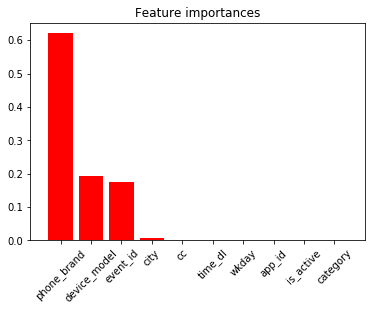

In [66]:
importances = dmodel.feature_importances_
std = np.std([dmodel.feature_importances_ for tree in importances],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for index,f in enumerate(X_train3.columns):
    print("%d. %s (%f)" % (index+1 , f, importances[indices[index]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train3.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train3.shape[1]), X_train3.columns, rotation=45)
plt.xlim([-1, X_train3.shape[1]])
plt.show()

Feature ranking:
1. phone_brand (0.378319)
2. device_model (0.264573)
3. event_id (0.173561)
4. city (0.063876)
5. cc (0.053293)
6. time_dl (0.029258)
7. wkday (0.019971)
8. app_id (0.013223)
9. is_active (0.003706)
10. category (0.000220)


Text(0.5,1,'Feature importances')

<Container object of 10 artists>

([<matplotlib.axis.XTick at 0x1a2afcbe48>,
 <a list of 10 Text xticklabel objects>)

(-1, 10)

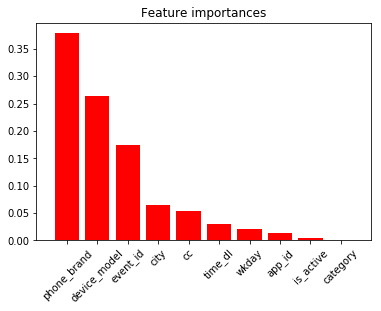

In [70]:
importances = rmodel.feature_importances_
std = np.std([rmodel.feature_importances_ for tree in importances],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for index,f in enumerate(X_train3.columns):
    print("%d. %s (%f)" % (index+1 , f, importances[indices[index]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train3.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train3.shape[1]), X_train3.columns, rotation=45)
plt.xlim([-1, X_train3.shape[1]])
plt.show()

## Playing with Cats

Trying out catboost for python.

In [ ]:
cat = traindf.drop(['gender','age', 'longitude', 'latitude','label_id', 'timestamp','time_dl', 'is_installed','device_id'], axis=1)



In [ ]:
#CatBoost
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
y = cat['group']
X= cat.drop(['group'], axis=1)
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)
categorical_features_indices = np.where(X_trainc.dtypes != np.float)[0]

model=CatBoostClassifier(iterations=10, depth=3, learning_rate=0.1)
model.fit(X_trainc, y_trainc,cat_features=categorical_features_indices,eval_set=(X_testc, y_testc),plot=True)

In [ ]:
train_pool = Pool(X_trainc, y_trainc, cat_features=categorical_features_indices)

model=CatBoostClassifier(iterations=10, depth=3, learning_rate=0.1).fit(train_pool, logging_level='Silent')
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_trainc.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

## Naive Bayes

Trying out different models to see which is the best route to analysis. Model ran decnetly fast and it handled the larger set well.

In [49]:
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report

model = naive_bayes.BernoulliNB()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Accuracy: 0.987
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1125
          1       0.97      1.00      0.99      1680
          2       0.97      1.00      0.99      1269
          3       0.99      1.00      1.00      2853
          4       0.96      0.97      0.96      3026
          5       0.97      1.00      0.98      2694
          6       0.99      0.98      0.98       440
          7       0.98      0.98      0.98      6542
          8       0.95      0.97      0.96      3281
          9       0.99      0.98      0.98      9550
         10       1.00      0.99      1.00     23111
         11       0.99      0.99      0.99     10585

avg / total       0.99      0.99      0.99     66156



In [50]:
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report

model1 = naive_bayes.BernoulliNB()
model1.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test2, model1.predict(X_test2)))
print(classification_report(y_test2, model1.predict(X_test2)))

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Accuracy: 0.986
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3613
          1       0.97      1.00      0.99      5745
          2       0.97      1.00      0.98      4107
          3       0.99      1.00      1.00      9531
          4       0.96      0.97      0.96      9827
          5       0.96      1.00      0.98      8875
          6       0.98      0.97      0.98      1432
          7       0.98      0.98      0.98     21780
          8       0.95      0.97      0.96     10862
          9       0.98      0.98      0.98     32058
         10       1.00      0.99      0.99     77520
         11       0.99      0.98      0.99     35167

avg / total       0.99      0.99      0.99    220517



In [55]:
model1 = naive_bayes.BernoulliNB()
model1.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

## Stochastic Gradient Descent

Trying Stochastic Gradient Descent model to see if I can come up with better numbers.

In [56]:
from sklearn.linear_model import SGDClassifier

In [63]:
sgd = SGDClassifier(loss='hinge',penalty = 'elasticnet', l1_ratio= .8, max_iter = 500, tol = .1)

In [64]:
#kills kernel
sgdmod = sgd.fit(X_train, y_train)

In [65]:
f1_score(y_test, sgdmodel.predict(X_test)) 

NameError: name 'f1_score' is not defined

## Graphing

Creating some graphs to better understand the data.

In [52]:
len(traindf.phone_brand.unique())

19

In [40]:
traindf[traindf['group'] ==10]
groupnum = []
countnum = []
for i in traindf.group.unique():
    groupnum.append(i)
    for j in traindf.phone_brand.unique():
        

,group,phone_brand,device_model,event_id,city,cc,time_dl,wkday,app_id,is_active,category
2,10,15,83,343,66,1,1643,2,1256,1,151
3,10,15,83,537,66,1,523,5,1256,0,151
4,10,15,83,1437,66,1,1402,1,1256,1,151
222,10,11,13,2831,34,0,414,3,1256,0,151
223,10,11,13,2670,90,0,2621,0,1256,1,151
224,10,11,13,2930,90,0,1865,1,1256,1,151
225,10,11,13,14,90,0,1689,1,1256,1,151
226,10,11,13,288,90,0,137,2,1256,0,151
227,10,11,13,689,90,0,2665,6,1256,0,151
228,10,11,13,1067,88,0,1486,0,1256,0,151
